In [574]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [575]:
HOUSING_PATH_FULL='C:/Users/samys/PycharmProjects/HousingPrices/data/Melbourne_housing_FULL.csv'

def load_housing_data(housing_path=HOUSING_PATH_FULL):
    return pd.read_csv(housing_path)

In [576]:
loaded_data = load_housing_data()
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [577]:
train_val_set = loaded_data.dropna(subset=['Price'])
final_test = loaded_data[loaded_data['Price'].isna()]
print(f"Number of rows in train_val_set: {len(train_val_set)}")
print(f"Number of rows in final_test: {len(final_test)}")

new_column_names = {'Lattitude': 'Latitude', 'Longtitude': 'Longitude'}
melb_data = train_val_set.rename(columns=new_column_names)

PRICE_MEAN = melb_data['Price'].mean()
print(f'PRICE_MEAN = {PRICE_MEAN}'  )
PRICE_MEDIAN = melb_data['Price'].median()
print(f'PRICE_MEDIAN = {PRICE_MEDIAN}')

Number of rows in train_val_set: 27247
Number of rows in final_test: 7610
PRICE_MEAN = 1050173.344955408
PRICE_MEDIAN = 870000.0


In [578]:
TRAINING_L_U = []
def remove_outliers_iqr_all(df, columns, factor=1.5, IS_TRAIN=False):
    df_clean = df.copy()
    outlier_mask = pd.Series(False, index=df_clean.index)

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        if IS_TRAIN:
            TRAINING_L_U.append([col, lower, upper])
        outlier_mask |= (df_clean[col] < lower) | (df_clean[col] > upper)

    num_outliers = outlier_mask.sum()
    df_clean = df_clean[~outlier_mask]

    print(f"Total number of outliers: {num_outliers}")
    print(f"Number of rows after removal: {len(df_clean)}")
    return df_clean


In [579]:
# EXTRA
# for name, pred in preds.items():

In [580]:
# cols = ["Distance", "Bedroom2", "Bathroom", "Car"]
cols = ["Distance", "Bedroom2", "Bathroom", "Car"]
melb_data = remove_outliers_iqr_all(melb_data, cols, IS_TRAIN=True)
melb_data = remove_outliers_iqr_all(melb_data, ['Price'], factor=1.5)

Total number of outliers: 2450
Number of rows after removal: 24797
Total number of outliers: 1040
Number of rows after removal: 23757


In [581]:
train_set, test_set = train_test_split(melb_data, test_size=0.2, random_state=42)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19005 entries, 18914 to 34692
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         19005 non-null  object 
 1   Address        19005 non-null  object 
 2   Rooms          19005 non-null  int64  
 3   Type           19005 non-null  object 
 4   Price          19005 non-null  float64
 5   Method         19005 non-null  object 
 6   SellerG        19005 non-null  object 
 7   Date           19005 non-null  object 
 8   Distance       19004 non-null  float64
 9   Postcode       19004 non-null  float64
 10  Bedroom2       14167 non-null  float64
 11  Bathroom       14166 non-null  float64
 12  Car            13891 non-null  float64
 13  Landsize       12320 non-null  float64
 14  BuildingArea   7200 non-null   float64
 15  YearBuilt      8231 non-null   float64
 16  CouncilArea    19002 non-null  object 
 17  Latitude       14309 non-null  float64
 18  Longitu

In [582]:
# train_set = remove_outliers_iqr_all(train_set, cols)


train_set['Price'] = np.log1p(train_set['Price'])
test_set['Price'] = np.log1p(test_set['Price'])

In [583]:
housing = train_set.copy()
numerical_features = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_set.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Latitude', 'Longitude', 'Propertycount']
Categorical features: ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Postcode'}>],
       [<Axes: title={'center': 'Bedroom2'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>],
       [<Axes: title={'center': 'Propertycount'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

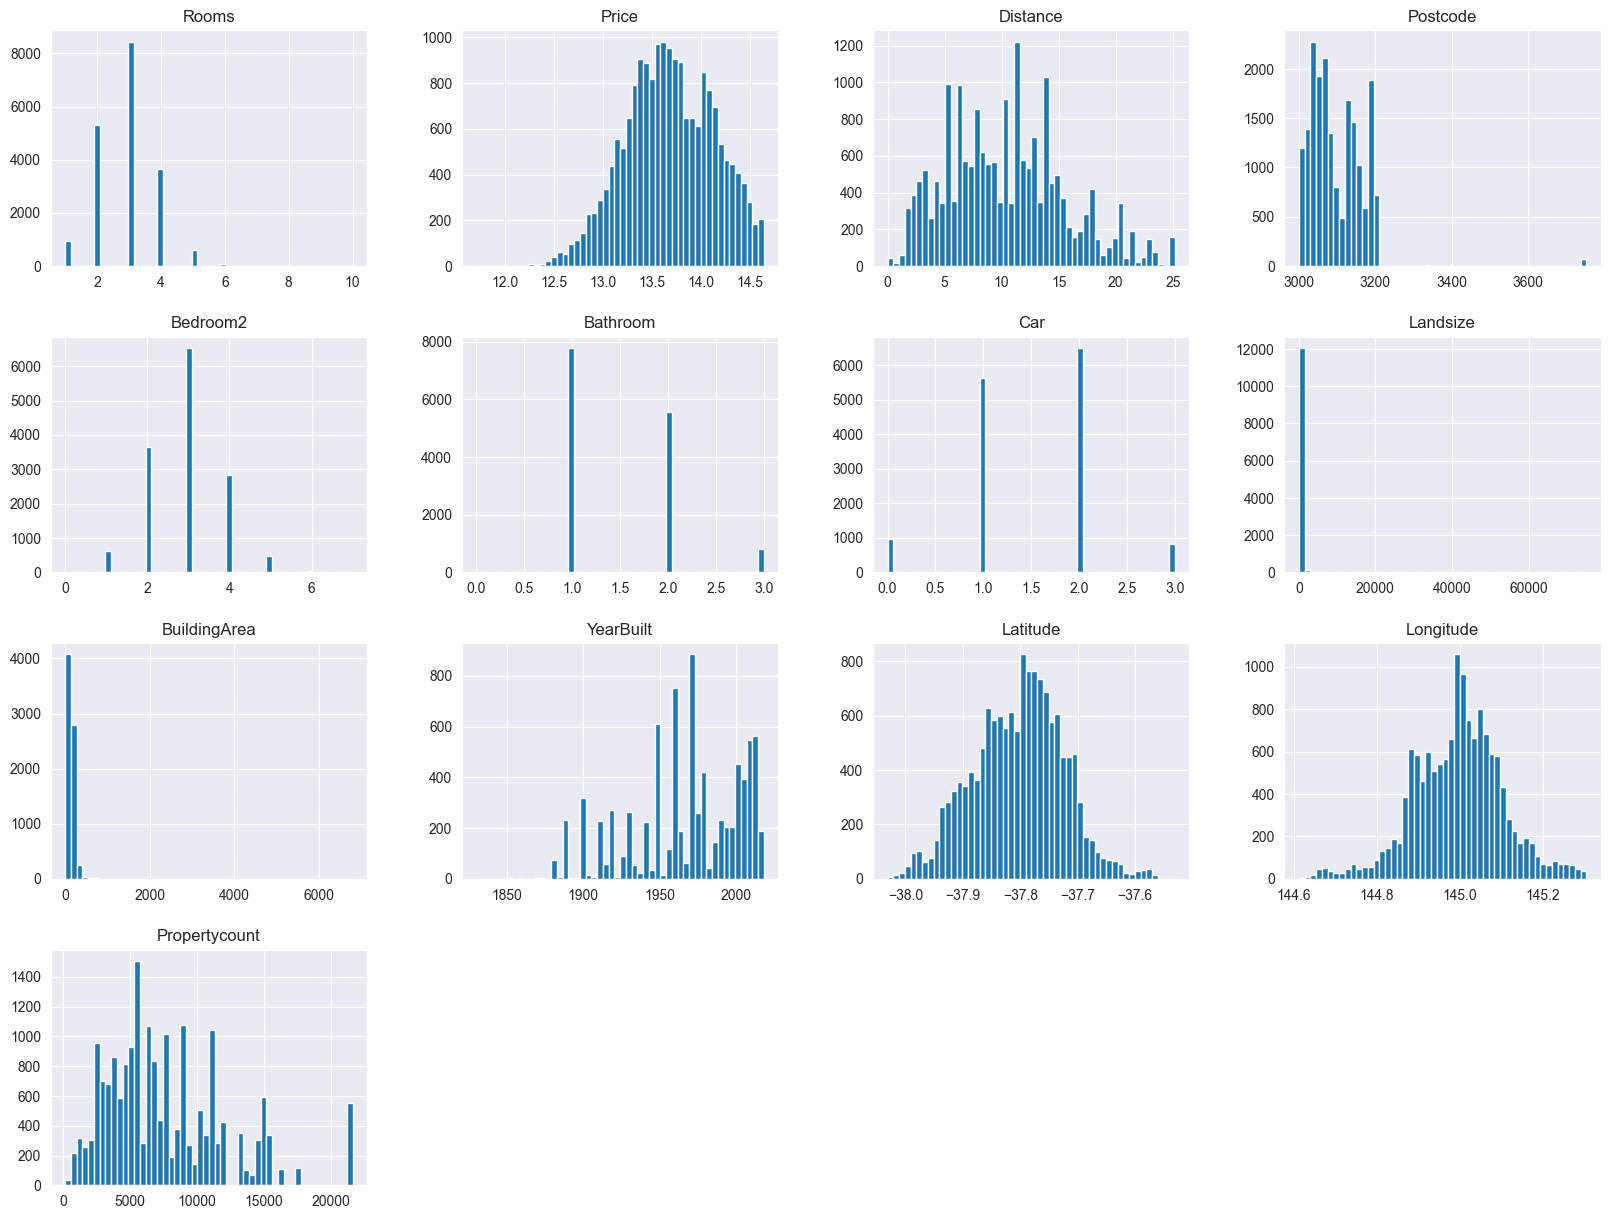

In [584]:
housing_num = housing[numerical_features]
housing.hist(bins=50, figsize=(20, 15))

In [585]:
corr_matrix = housing_num.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price            1.000000
Rooms            0.526407
Bedroom2         0.479045
Bathroom         0.345700
Longitude        0.267527
BuildingArea     0.260362
Car              0.230191
Postcode         0.195620
Landsize         0.051498
Distance        -0.099173
Propertycount   -0.102495
Latitude        -0.261767
YearBuilt       -0.372922
Name: Price, dtype: float64

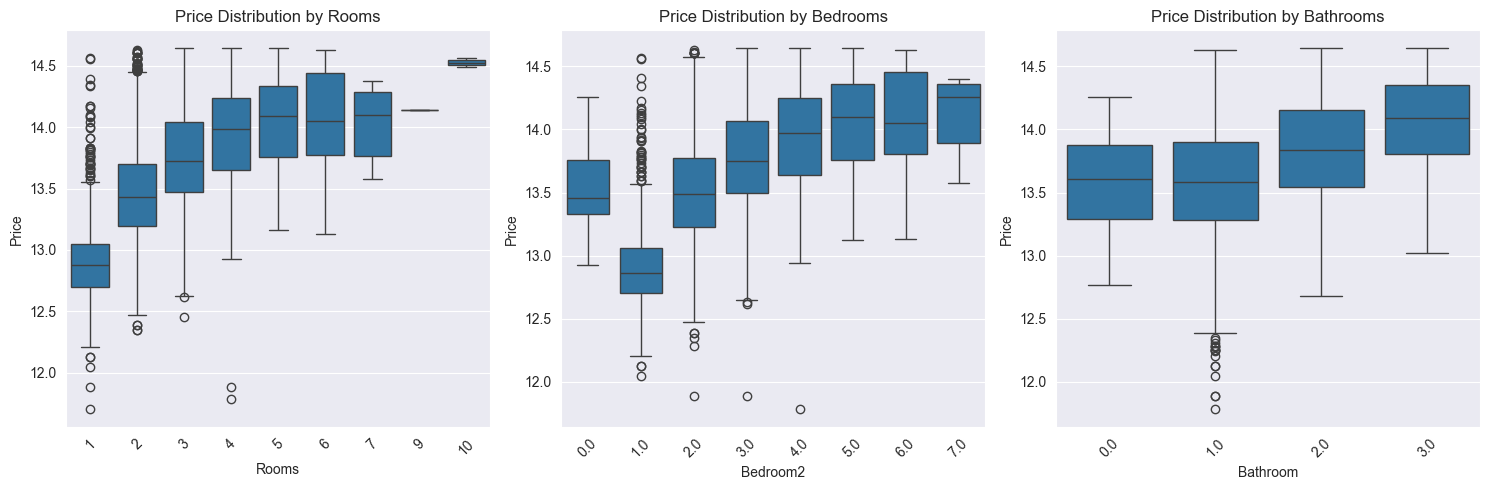

In [586]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Price vs Rooms
sns.boxplot(data=housing, x='Rooms', y='Price', ax=axes[0])
axes[0].set_title('Price Distribution by Rooms')
axes[0].tick_params(axis='x', rotation=45)

# Price vs Bedrooms
sns.boxplot(data=housing, x='Bedroom2', y='Price', ax=axes[1])
axes[1].set_title('Price Distribution by Bedrooms')
axes[1].tick_params(axis='x', rotation=45)

# Price vs Bathrooms
sns.boxplot(data=housing, x='Bathroom', y='Price', ax=axes[2])
axes[2].set_title('Price Distribution by Bathrooms')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [587]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19005 entries, 18914 to 34692
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         19005 non-null  object 
 1   Address        19005 non-null  object 
 2   Rooms          19005 non-null  int64  
 3   Type           19005 non-null  object 
 4   Price          19005 non-null  float64
 5   Method         19005 non-null  object 
 6   SellerG        19005 non-null  object 
 7   Date           19005 non-null  object 
 8   Distance       19004 non-null  float64
 9   Postcode       19004 non-null  float64
 10  Bedroom2       14167 non-null  float64
 11  Bathroom       14166 non-null  float64
 12  Car            13891 non-null  float64
 13  Landsize       12320 non-null  float64
 14  BuildingArea   7200 non-null   float64
 15  YearBuilt      8231 non-null   float64
 16  CouncilArea    19002 non-null  object 
 17  Latitude       14309 non-null  float64
 18  Longitu

In [588]:

drop_cols = ["BuildingArea", "YearBuilt", "Postcode", "Latitude", "Longitude", "Address"]
housing_clean = housing.drop(columns=drop_cols)

important_dropna_cols = ["Distance", "CouncilArea", "Regionname","Bedroom2", "Bathroom", "Car", "Landsize", "Propertycount"]
housing_clean = housing_clean.dropna(subset=important_dropna_cols)

# median_impute_cols = ["Landsize"]
# mean_impute_cols = ["Propertycount"]

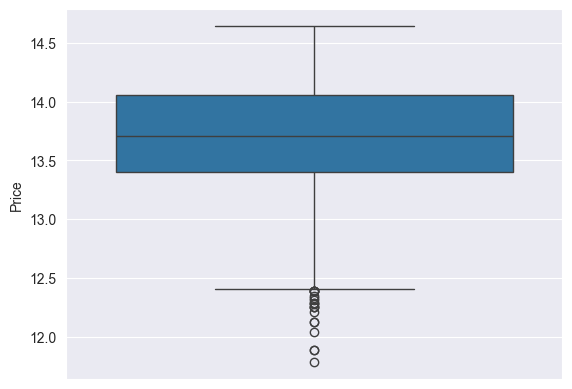

In [589]:

sns.boxplot(data=housing_clean, y='Price')
plt.show()

In [590]:

median_imputer = SimpleImputer(strategy="median")
mean_imputer = SimpleImputer(strategy="mean")

imputer_transform = ColumnTransformer(transformers=[
    ("median_imputer", median_imputer, median_impute_cols),
    ("mean_imputer", mean_imputer, mean_impute_cols)
],
    remainder="passthrough",
    verbose_feature_names_out=False)

numerical_cols = housing_clean.select_dtypes(include=['int64', 'float64']).columns.drop('Price').tolist()
categorical_cols = housing_clean.drop(columns=numerical_cols + ['Price']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer_transform', imputer_transform),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])


Numerical columns: ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']
Categorical columns: ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


In [591]:
X_train = housing_clean.drop(columns=["Price"])
Y_train = housing_clean["Price"]

X_train_transformed = pipeline.fit_transform(X_train)


In [592]:

test_set_clean = test_set.drop(columns=drop_cols)
test_set_clean = test_set_clean.dropna(subset=important_dropna_cols)


X_test = test_set_clean.drop(columns=["Price"])
Y_test = test_set_clean["Price"]

X_test_transformed = pipeline.transform(test_set_clean)


In [593]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [594]:

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import HuberRegressor, RANSACRegressor

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'Huber': HuberRegressor(),
    'RANSAC': RANSACRegressor(random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

In [595]:
preds = {}

for name, model in models.items():
    model.fit(X_train_transformed, Y_train)
    pred = model.predict(X_test_transformed)
    preds[name] = pred


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 12107, number of used features: 344
[LightGBM] [Info] Start training from score 13.710910


C:\Users\samys\PycharmProjects\HousingPrices\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\samys\PycharmProjects\HousingPrices\.venv\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [596]:
def print_error(name, y_pred_log):
    print('---------------------------------------------------------\n')
    print(f'Model: {name}')
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(Y_test)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Выводим результаты
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2 * 100:.2f}%")
    print(f"Predicted/Price_MEAN Error: {(mae / PRICE_MEAN * 100):.2f} %")
    print(f"Predicted/Price_MEADIAN: {(mae / PRICE_MEDIAN * 100):.2f} %")

In [597]:
for name, pred in preds.items():
    print_error(name, pred)

---------------------------------------------------------

Model: Linear
Mean Absolute Error (MAE): 158026.05782150142
Mean Squared Error (MSE): 48382859681.17739
Root Mean Squared Error (RMSE): 219961.04128044445
R² Score: 75.50%
Predicted/Price_MEAN Error: 15.05 %
Predicted/Price_MEADIAN: 18.16 %
---------------------------------------------------------

Model: Ridge
Mean Absolute Error (MAE): 157694.96097929415
Mean Squared Error (MSE): 48012531731.67278
Root Mean Squared Error (RMSE): 219117.6207694689
R² Score: 75.69%
Predicted/Price_MEAN Error: 15.02 %
Predicted/Price_MEADIAN: 18.13 %
---------------------------------------------------------

Model: Lasso
Mean Absolute Error (MAE): 207532.26631617048
Mean Squared Error (MSE): 76764171822.70187
Root Mean Squared Error (RMSE): 277063.47977079527
R² Score: 61.13%
Predicted/Price_MEAN Error: 19.76 %
Predicted/Price_MEADIAN: 23.85 %
---------------------------------------------------------

Model: RandomForest
Mean Absolute Error (MAE

In [598]:
def crossValidationFit():
    # Create scorers for multiple metrics
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    # Set up k-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation for different metrics
    rmse_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                  scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                scoring=r2_scorer, cv=kf)
    mae_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                 scoring='neg_mean_absolute_error', cv=kf)


    print("Cross-validation results:")
    print(f"RMSE scores: {-rmse_scores}")  # Negative because scorer is negative for minimization
    print(f"Average RMSE: {-rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
    print(f"\nR² scores: {r2_scores}")
    print(f"Average MAE: {r2_scores.mean():.4f} (+/- {r2_scores.std() * 2:.4f})")
    print(f"\nMAE scores: {mae_scores}")
    print(f"Average MAE: {mae_scores.mean():.4f} (+/- {mae_scores.std() * 2:.4f})")


In [599]:
crossValidationFit()

Cross-validation results:
RMSE scores: [190275.03883659 187687.21943144 186927.88474346 180172.35619986
 190433.91059795]
Average RMSE: 187099.2820 (+/- 7459.8943)

R² scores: [0.81384206 0.81912697 0.81704383 0.83472229 0.81599693]
Average MAE: 0.8201 (+/- 0.0150)

MAE scores: [-135636.24063349 -132202.50067512 -131795.7824305  -131306.05419974
 -137071.01900855]
Average MAE: -133602.3194 (+/- 4618.6244)


In [600]:
from scipy.stats import uniform, randint

def randomSearchFit():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    param_dist = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'iterations': [200, 500, 1000],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

    param_random_prof = {
        'iterations': randint(500, 1500),                    # с расчетом на раннюю остановку
        'learning_rate': uniform(0.01, 0.3),                 # от 0.01 до 0.31
        'depth': randint(4, 11),                             # от 4 до 10
        'l2_leaf_reg': uniform(1, 9),                        # от 1 до 10
        'bagging_temperature': uniform(0, 1.5),              # от 0 до 1.5
        'random_strength': uniform(0, 10),                   # от 0 до 10
        'rsm': uniform(0.5, 0.5),                            # от 0.5 до 1.0
        'subsample': uniform(0.6, 0.4),                      # от 0.6 до 1.0
        'scale_pos_weight': uniform(0.5, 4.5),               # от 0.5 до 5.0 (только для бинарной классификации)
    }


    cat = CatBoostRegressor(verbose=0, random_state=42)

    search = RandomizedSearchCV(
        cat,
        param_distributions=param_dist,
        n_iter=20,
        scoring=rmse_scorer,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_transformed, Y_train)

    print("Лучшие параметры:", search.best_params_)
    print("Лучшее значение RMSE (на CV):", -search.best_score_)


    best_model = search.best_estimator_

    y_pred_log = best_model.predict(X_test_transformed)

    print_error("CatBoost (поиск по сетке)", y_pred_log)
    return best_model


In [601]:
random_search_best = randomSearchFit()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 10}
Лучшее значение RMSE (на CV): 0.03000316435240638
---------------------------------------------------------

Model: CatBoost (поиск по сетке)
Mean Absolute Error (MAE): 126613.85450136646
Mean Squared Error (MSE): 32437609475.834602
Root Mean Squared Error (RMSE): 180104.44046673196
R² Score: 83.57%
Predicted/Price_MEAN Error: 12.06 %
Predicted/Price_MEADIAN: 14.55 %


In [602]:

def gridSearchFit():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cat_grid = CatBoostRegressor(verbose=0, random_state=42)

    param_grid_prof = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [0, 1, 5, 10],
    'rsm': [0.5, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3, 5]  # применимо только при дисбалансе классов в бинарной классификации
    }


    param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 300, 500]
    }

    grid_search = GridSearchCV(
        estimator=cat_grid,
        param_grid=param_grid,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )

    grid_search.fit(X_train_transformed, Y_train)
    print("Лучшая комбинация гиперпараметров:")
    print(grid_search.best_params_)

    print("\nЛучший (наименьший) RMSE (по CV):")
    print(f"{-grid_search.best_score_:.4f}")
    best_model = grid_search.best_estimator_

    grid_predict = best_model.predict(X_test_transformed)

    print_error("GridSearch CatBoost (поиск по сетке)", grid_predict)
    return best_model

In [603]:
grid_search_best = gridSearchFit()

Лучшая комбинация гиперпараметров:
{'depth': 8, 'iterations': 500, 'learning_rate': 0.1}

Лучший (наименьший) RMSE (по CV):
0.0301
---------------------------------------------------------

Model: GridSearch CatBoost (поиск по сетке)
Mean Absolute Error (MAE): 126877.36472366992
Mean Squared Error (MSE): 32259868296.715187
Root Mean Squared Error (RMSE): 179610.3234692126
R² Score: 83.66%
Predicted/Price_MEAN Error: 12.08 %
Predicted/Price_MEADIAN: 14.58 %


In [604]:
# good_model = models['CatBoost']
# good_model = random_search_best
good_model = grid_search_best

random_house = test_set_clean.sample(n=5)

display(random_house)

random_house_X = random_house.drop(columns=["Price"])
random_house_Y = random_house["Price"]

random_house_transformed = pipeline.transform(random_house_X)
random_prediction = good_model.predict(random_house_transformed)

for i, price in enumerate(random_house_Y):
    print(f'True value : {np.expm1(price)}')
    print(f'Predicted value : {np.expm1(random_prediction[i])}')
    print(f'Error : {abs(np.expm1(price) - np.expm1(random_prediction[i]))}')
    print('---------------------------------------------')


,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Regionname,Propertycount
8091,Prahran,3,h,14.357835,S,Jellis,28/05/2016,4.5,3.0,2.0,1.0,272.0,Stonnington City Council,Southern Metropolitan,7717.0
18359,Werribee,3,h,13.087774,S,Ray,12/08/2017,14.7,3.0,1.0,2.0,569.0,Wyndham City Council,Western Metropolitan,16166.0
31167,Eltham,3,h,13.618280,S,Morrison,10/02/2018,18.0,3.0,1.0,2.0,677.0,Banyule City Council,Eastern Metropolitan,6990.0
8227,Preston,3,h,13.592368,PI,Chambers,18/03/2017,8.8,3.0,1.0,2.0,516.0,Darebin City Council,Northern Metropolitan,14577.0
34568,Newport,4,h,13.955273,S,Williams,24/02/2018,6.2,4.0,2.0,1.0,418.0,Hobsons Bay City Council,Western Metropolitan,5498.0


True value : 1719999.9999999998
Predicted value : 1721764.6147337076
Error : 1764.6147337078582
---------------------------------------------
True value : 483000.00000000023
Predicted value : 503377.5612549228
Error : 20377.56125492259
---------------------------------------------
True value : 820999.9999999998
Predicted value : 885302.0359030379
Error : 64302.03590303811
---------------------------------------------
True value : 800000.0000000005
Predicted value : 891318.2313057858
Error : 91318.23130578536
---------------------------------------------
True value : 1150000.0000000005
Predicted value : 1379579.9642103298
Error : 229579.96421032934
---------------------------------------------


In [605]:
print(TRAINING_L_U)

[['Distance', np.float64(-4.999999999999998), np.float64(25.4)], ['Bedroom2', np.float64(-1.0), np.float64(7.0)], ['Bathroom', np.float64(-0.5), np.float64(3.5)], ['Car', np.float64(-0.5), np.float64(3.5)]]


In [606]:
def filter_by_training_bounds(df, training_bounds):
    df_filtered = df.copy()
    mask = pd.Series(True, index=df.index)
    # Используем входной параметр training_bounds вместо глобальной переменной
    bounds = [x for x in training_bounds if x[0] != 'Price']
    for col, lower, upper in bounds:
        mask &= (df_filtered[col] >= lower) & (df_filtered[col] <= upper)
    return df_filtered[mask]

# Использование:
filtered_final_set = filter_by_training_bounds(final_test, TRAINING_L_U)
print(f"Число подходящих строк: {len(filtered_final_set)} из {len(final_test)}")

Число подходящих строк: 5064 из 7610


In [608]:
# Подготовка данных для предсказания
final_set = final_test.copy()
filtered_final_X = filtered_final_set.drop(columns=["Price"])
filtered_final_transformed = pipeline.transform(filtered_final_X)

# Получение предсказаний
# predictions = models['CatBoost'].predict(filtered_final_transformed)
predictions = good_model.predict(filtered_final_transformed)

# Преобразование предсказанных логарифмированных цен обратно
predicted_prices = np.expm1(predictions)

# Запись предсказанных цен в DataFrame
final_set.loc[filtered_final_set.index, 'Price'] = predicted_prices

# Сохранение в CSV
final_set.to_csv('predicted_house_prices.csv', index=False)
